In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from mlxtend.preprocessing import standardize
from mlxtend.plotting import plot_decision_regions

%load_ext autoreload
%autoreload 2
%matplotlib inline
if os.name == 'posix':
    %config InlineBackend.figure_format = 'retina' #retina display settings

### Load dataset with pandas & explore feature selection

* creating new feature: screen diagonal size
* removing screen width and height

In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df['diag'] = np.sqrt(df.px_height**2 + df.px_width**2)
df = df.drop(['px_width', 'px_height'], axis=1)

df_test['diag'] = np.sqrt(df_test.px_height**2 + df_test.px_width**2)
df_test = df_test.drop(['px_width', 'px_height'], axis=1)
df_test.drop('id', axis=1, inplace=True)

### Correlations
Plotting correlation matrix for the features that most correlate with `price_range`

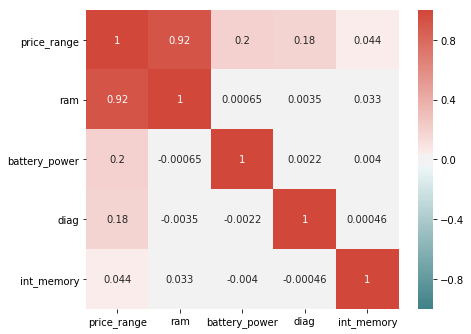

In [3]:
int_cols = df.corr().loc['price_range'].abs().sort_values(ascending=False)[:5].index
corr = df[int_cols].corr()
corr.values[np.triu_indices_from(corr)] = np.abs(corr.values[np.triu_indices_from(corr)] )

fig = plt.figure(figsize=(7, 5.5))
sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(200, 15, as_cmap=True), vmin=-1, vmax=1);

Correlation between `price_range` and other columns, printed from highest to lowest

In [4]:
print(df.corr().loc['price_range'].abs().sort_values(ascending=False)[1:])
interesting_features = ['ram', 'battery_power', 'diag']

ram              0.917046
battery_power    0.200723
diag             0.180385
int_memory       0.044435
sc_w             0.038711
pc               0.033599
touch_screen     0.030411
mobile_wt        0.030302
three_g          0.023611
sc_h             0.022986
fc               0.021998
talk_time        0.021859
blue             0.020573
wifi             0.018785
dual_sim         0.017444
four_g           0.014772
clock_speed      0.006606
n_cores          0.004399
m_dep            0.000853
Name: price_range, dtype: float64


### Boxenplots

Plotting distribution of ram and internal memory as a function of the price range

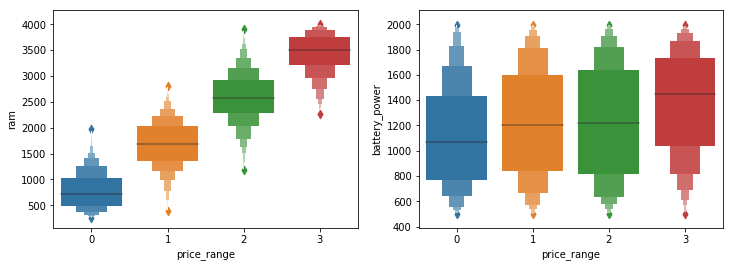

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.boxenplot(x="price_range", y="ram", data=df, ax=ax1)
sns.boxenplot(x="price_range", y="battery_power", data=df, ax=ax2)

### Scatter plots

2D visualization of the `price_range` (color-code) and a function of two features.

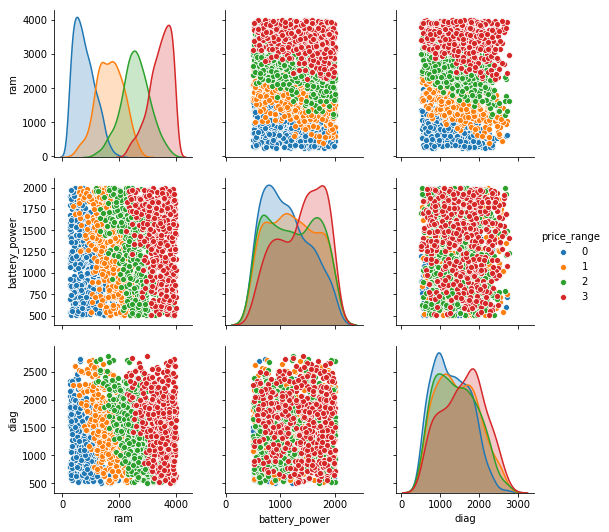

In [6]:
sns.pairplot(df, vars=['ram', 'battery_power', 'diag'], hue="price_range");

### Normalizing data
Normalize all data using mean and standard deviationexcept for the target column

In [7]:
df_norm, params_std = standardize(df, return_params=True)
df_norm['price_range'] = df.price_range
df_norm_test = standardize(df_test, params=params_std)

### Selecting features and target

In [8]:
X = df_norm[interesting_features].values
y = df_norm[['price_range']].values.ravel()

### Plot 2D

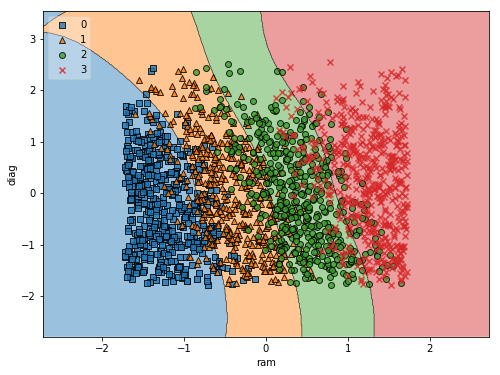

In [9]:
two_features = ['ram', 'diag']
target = 'price_range'

X_plot = df_norm[two_features].values
clf = svm.SVC(kernel='rbf', gamma=0.4, C=1)

clf.fit(X_plot, y)

fig, ax = plt.subplots(1, figsize=(8, 6))
plot_decision_regions(X_plot, y, clf=clf, legend=2, hide_spines=False, ax=ax)
ax.set(xlabel=two_features[0], ylabel=two_features[1]);

### Cross validation for SVC with rbf kernel

In [10]:
# clf = svm.SVC(kernel='poly', degree=1, gamma=1., C=1)
clf = svm.SVC(kernel='rbf', gamma=.4, C=10)
clf = svm.SVC(kernel='linear', C=10)


clf.fit(X, y)
predicted_y = clf.predict(X)

print(f'Using all dataset: {accuracy_score(predicted_y, y)}')
print(f'Using cross validation: {cross_val_score(clf, X, y, cv=5).mean()}')

Using all dataset: 0.9455
Using cross validation: 0.9445


### Grid search
Finding optimum parameters for scv model

In [11]:
svc = svm.SVC()

param_grid = [
  {'C': np.logspace(-2, 3, 30), 'kernel': ['linear']},
  {'C': np.logspace(-6, 6, 30), 'gamma': np.logspace(-6, 6, 30), 'kernel': ['rbf']},
  #{'C': np.logspace(-6, 6, 20), 'gamma': np.logspace(-6, 6, 20), 'degree':[2,3,4] ,'kernel': ['poly']}
 ]

clf = GridSearchCV(svc, param_grid=param_grid, cv=5, verbose=2, n_jobs=8)
clf.fit(X,y)

Fitting 5 folds for each of 930 candidates, totalling 4650 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done 200 tasks      | elapsed:   12.7s
[Parallel(n_jobs=8)]: Done 403 tasks      | elapsed:   38.0s
[Parallel(n_jobs=8)]: Done 686 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 1051 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 1496 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 2023 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 2630 tasks      | elapsed:  5.4min
[Parallel(n_jobs=8)]: Done 3319 tasks      | elapsed:  6.8min
[Parallel(n_jobs=8)]: Done 4088 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 4650 out of 4650 | elapsed: 13.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid=[{'C': array([1.00000e-02, 1.48735e-02, 2.21222e-02, 3.29034e-02, 4.89390e-02,
       7.27895e-02, 1.08264e-01, 1.61026e-01, 2.39503e-01, 3.56225e-01,
       5.29832e-01, 7.88046e-01, 1.17210e+00, 1.74333e+00, 2.59294e+00,
       3.85662e+00, 5.73615e+00, 8.53168e+00, 1.26896e+01, 1.88739...8e+03,
       2.21222e+04, 5.73615e+04, 1.48735e+05, 3.85662e+05, 1.00000e+06]), 'kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [12]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']

print(f'Optimal parameters: {clf.best_params_}')
print(f'CV best accuracy: {clf.best_score_}')

Optimal parameters: {'C': 8531.678524172814, 'gamma': 0.03562247890262444, 'kernel': 'rbf'}
CV best accuracy: 0.9465


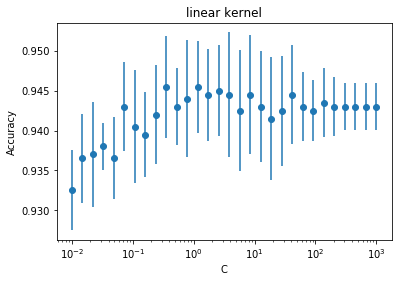

In [37]:
xye = np.array([[p['C'], m, s] for m,s,p in zip(means, stds, params) if p['kernel']=='linear']).T

fig, ax = plt.subplots(1, figsize=(6,4))
ax.errorbar(*xye, fmt='o')
ax.set_xscale('log')
ax.set(xlabel='C', ylabel='Accuracy', title='linear kernel');

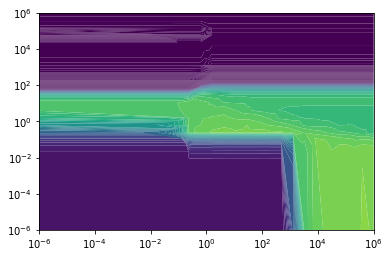

In [38]:
xyz = [[p['C'], p['gamma'], m] for m, p in zip(means, params) if p['kernel']=='rbf']

plt.tricontourf(*(zip(*xyz)), 100, antialiased=True, vmin=0.7, vmax=1)
plt.xscale('log')
plt.yscale('log')